<sub>Mario Stanke, University of Greifswald, Germany</sub>
# A Neural Network to Classify n-Gons (Vielecke)
<sup>(Monday afternoon)</sup>

This notebook gives the first example of a neural network for a classification task. **Is there a triangle, quadrilateral, pentagon or hexagon in this image?**

<img src="ngon-ex.png" alt="noisy n-gon" width="150"/>
Solution: (expand the next cell)

There is a pentagon.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle # to load 'pickled' numpy arrays (serialized, compressed)
from tensorflow.keras.layers import Dense, Flatten
tf.keras.backend.set_floatx('float64')

In [2]:
# load image data as numpy arrays (generated with a separate script available on request)
# Pickling is a way to store datastructures on a drive - or cucumbers in a glass.
# load training data
with open("../data/ngons/ngon_train.pkl", "rb") as f:
    Xtrain, ytrain_class = pickle.load(f)
# load test data
with open("../data/ngons/ngon_test.pkl", "rb") as f:
    Xtest, ytest_class = pickle.load(f)

num_train = Xtrain.shape[0]
num_test = Xtest.shape[0]
height = Xtrain.shape[1]
width = Xtrain.shape[2]
img_size_flat = width * height

num_classes = 4 # 0, 1, 2, 3 for 3-, 4-, 5-, 6-gons

# one-hot encode output classes
ytrain = np.eye(num_classes, dtype=float)[ytrain_class]
ytest = np.eye(num_classes, dtype=float)[ytest_class]
print("Fraction of classes:", np.mean(ytrain, axis=0)) # close to 1/4 each

# normalize input to [0,1]
Xtrain = Xtrain / 255.
Xtest = Xtest / 255.

print("Size of training set is", num_train, ", size of test set is", num_test)

# Number of classes
num_classes = 4 # 0, 1, 2, 3 for 3, ..., 6 gons


Fraction of classes: [0.2567 0.2409 0.2502 0.2522]
Size of training set is 10000 , size of test set is 2000


In [3]:
# Function to plot 8 images in a 2x4 grid, and writing the true and predicted classes below each image.

def plot_images(images, class_true, class_pred=None):
    assert len(images) == len(class_true) == 16

    # Create figure with sub-plots.
    fig, axes = plt.subplots(2, 8)
    fig.subplofigsize=(18, 16)

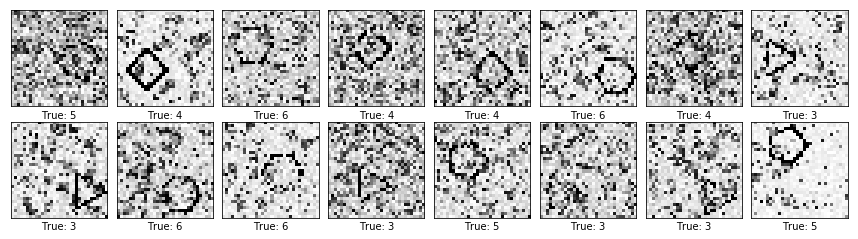

In [4]:
def plot_images(images, class_true, class_pred = None):
    """ Plot 16 (sample) images with their true and predicted classes"""
    assert len(images) == len(class_true) == 16

    # Create figure with sub-plots.
    fig, axes = plt.subplots(2, 8, figsize=(15, 4))
    fig.subplots_adjust(hspace=0.05, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], interpolation = 'none', cmap = 'binary') # plot image

        # display also true and predicted classes
        if class_pred is None:
            xlabel = "True: {0}".format(3 + class_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(3 + class_true[i], 3 + class_pred[i])

        ax.set_xlabel(xlabel)

        # remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])


plot_images(Xtrain[0:16], ytrain_class[0:16])

## Create Datasets

In [5]:
print(Xtrain.shape, ytrain.shape)

(10000, 32, 32) (10000, 4)


In [6]:
# both datasets have batch_size 32, the training data is repeated infinitely
train_ds = tf.data.Dataset.from_tensor_slices((Xtrain, ytrain)).batch(32).repeat()
test_ds = tf.data.Dataset.from_tensor_slices((Xtest, ytest)).batch(32)

## Create Neural Network Model
We will use ```tf.keras```, the high-level approach to neural network design and learning. 
As we will repeat the training with different regularization parameters (*weight decay*) we put this into a function.

In [7]:
# Perform the neural network training and report the model, the training history and loss and accuracy on the test set.
   
np.random.seed(1) # so we all get the same pseudorandom results

model = tf.keras.models.Sequential()

# Flatten unrolls the 2-dim input to a vector of size height * width
model.add(Flatten(input_shape = (height, width)))

# make a fully connected layer with 3200 units (more on this choice in tomorrow's lecture)
model.add(Dense(3200, activation = tf.nn.relu))

# final layer has one output unit per class
model.add(Dense(4, activation = tf.nn.softmax))

model.summary()

# define the loss, optimization algorithm and prepare the model for gradient computation 
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# execute the actual training
history = model.fit(Xtrain, ytrain, epochs = 30, validation_split = 0.2, verbose = 1, batch_size = 64) # takes ~3m

test_loss, test_acc = model.evaluate(test_ds)
print("Loss on test set:", test_loss, "\nAccuracy on test set:", test_acc)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 3200)              3280000   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 12804     
Total params: 3,292,804
Trainable params: 3,292,804
Non-trainable params: 0
_________________________________________________________________
Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 4s 525us/sample - loss: 1.4666 - accuracy: 0.2565 - val_loss: 1.3844 - val_accuracy: 0.2775
Epoch 2/30
8000/8000 [==============================] - 4s 476us/sample - loss: 1.3695 - accuracy: 0.3165 - val_loss: 1.3971 - val_accuracy: 0.2825
Epoch 3/30
8000/8000 [==========

### Plot the training history

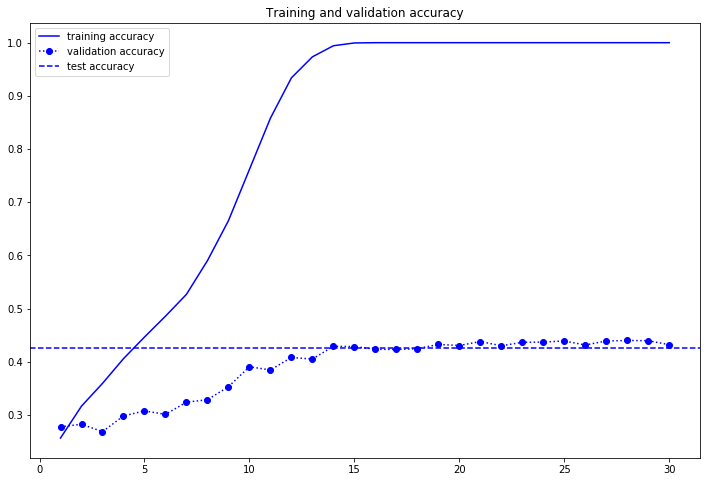

In [8]:
fig, ax = plt.subplots(figsize = (12, 8))

ax.set_title('Training and validation accuracy')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

ax.plot(epochs, acc, color = "blue", label = "training accuracy")
ax.plot(epochs, val_acc, "o:", color = "blue", label = "validation accuracy")
ax.axhline(y = test_acc, color = "blue", linestyle = "--", label = "test accuracy")

ax.legend();

From above plot we see that the model classifies training data much better than test date (overfit). It indicates that a model with fewer parameters or regularization could be better.

# Make Predictions and Examine Errors

Predicted class probabilities for 3, 4, 5, 6 for the first 16 images:
 [[0.    0.021 0.964 0.015]
 [0.967 0.02  0.012 0.001]
 [0.616 0.066 0.135 0.182]
 [0.656 0.054 0.217 0.073]
 [0.166 0.481 0.035 0.318]
 [0.046 0.623 0.326 0.005]
 [0.125 0.001 0.144 0.73 ]
 [0.001 0.975 0.019 0.005]
 [0.    0.01  0.621 0.369]
 [0.003 0.006 0.713 0.279]
 [0.994 0.001 0.005 0.   ]
 [0.027 0.331 0.025 0.617]
 [0.64  0.107 0.143 0.11 ]
 [0.546 0.206 0.028 0.22 ]
 [0.    0.08  0.917 0.003]
 [0.183 0.007 0.808 0.002]]


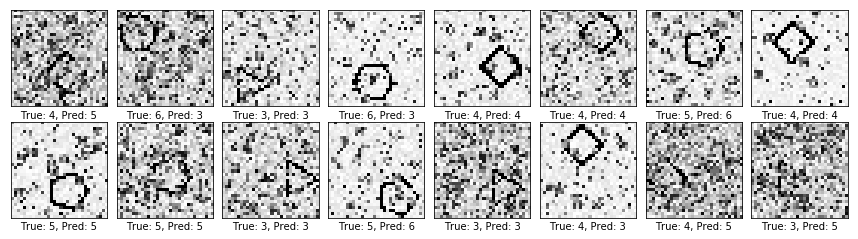

In [9]:
ytest_pred = model(Xtest)
print("Predicted class probabilities for 3, 4, 5, 6 for the first 16 images:\n", ytest_pred[0:16].numpy().round(3))

ytest_predclass = np.argmax(ytest_pred, axis = 1)
plot_images(Xtest[0:16], ytest_class[0:16], ytest_predclass[0:16])

### Not impressed? Wait until tomorrow ...